# A usecase on Google queries
This use case will show a complete retrieval system using
- TfIdf vectorization
- LDA for topic modeling retrieval

## Dataset
The dataset is a toy example of 1543 titles and web page snippets collected from Google using [SerpAPI](https://serpapi.com/)

In particular, we run a set of queries $Q = (q_1, \dots, q_n)$. For each query we collected the first 3 pages of google results in a set of rankings $A = (a_1, \dots, a_n)$. For the ground truth, we assume that the relevant documents for a query $q_i$ are those in $a_i$.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import pymongo
import json
import yaml

In [3]:
db = pymongo.MongoClient()['google']['answers']
print(yaml.dump(db.find_one(), allow_unicode=True, default_flow_style=False))

_id: !!python/object/new:bson.objectid.ObjectId
  state: !!binary |
    ZBsOXVPJIW/65AqI
about_page_link: https://www.google.com/search?q=About+https://www.deliciousmagazine.co.uk/collections/vegetarian-recipes-from-around-the-world/&tbm=ilp&ilps=AB_Lh3qedrt1ujpKNKV3D4eFKh7Q2R3h8g
about_page_serpapi_link: https://serpapi.com/search.json?engine=google_about_this_result&google_domain=google.com&ilps=AB_Lh3qedrt1ujpKNKV3D4eFKh7Q2R3h8g&q=About+https%3A%2F%2Fwww.deliciousmagazine.co.uk%2Fcollections%2Fvegetarian-recipes-from-around-the-world%2F
about_this_result:
  source:
    description: deliciousmagazine.co.uk was first indexed by Google more than 10
      years ago
    icon: https://serpapi.com/searches/6419aa5d3824270b8a684691/images/c14a9d40761606812cf3c209828b3c9e5a130e85d00f153274283af2ac43ccabab6435fec9d1126906a5d39b30eb6892.png
    security: secure
    source_info_link: https://www.deliciousmagazine.co.uk/collections/vegetarian-recipes-from-around-the-world/
cached_page_link: http

In [4]:
def get_documents(db, mongo_query=None):
    if mongo_query is None:
        mongo_query = {}
    project = {'_id': 0, 'position': 1, 'query_data': 1, 'snipped': 1, 'title': 1}
    data = []
    for record in db.find(mongo_query, project):
        r = {}
        r['query'] = record['query_data']['q']
        text = [record['title']]
        try:
            text.append(record['snippet'])
        except KeyError:
            pass
        r['document'] = ". ".join(text)
        r['ranking'] = record['position']
        data.append(r)
    return pd.DataFrame(data)

In [5]:
D = get_documents(db)

In [6]:
D.head()

,query,document,ranking
0,best ethnic vegetarian recipes,Vegetarian recipes from around the world,1
1,best ethnic vegetarian recipes,International Vegetarian Recipes • Curious Cui...,2
2,best ethnic vegetarian recipes,14 Best International Vegetarian Recipes - Gre...,3
3,best ethnic vegetarian recipes,These Are Some of the Best Vegetarian Dishes F...,4
4,best ethnic vegetarian recipes,15 Global Vegetarian Recipes | olivemagazine,5


In [7]:
D['query'].unique()

array(['best ethnic vegetarian recipes',
       'typical dishes of the french cousine',
       'best 2023 boardgames for 4 players', 'champions league',
       'typical dishes of the italian cousine',
       'introductory wargames with solo play mode', 'europa league',
       'mexican beef dishes', 'best fast food in the united states',
       'recipes for a christmass dinner'], dtype=object)

## Retrieval

In [8]:
from corpus import Corpus

### Add relevant bigrams and trigrams

In [9]:
C = Corpus(documents=D.document.values, lemma=True, lowercase=True)

In [10]:
C.index_bigrams()
C.add_bigrams()
C.add_trigrams()
C.create_dictionary()

### TfIdf

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, token_pattern=None, lowercase=False)
X = vectorizer.fit_transform(C.bag_of_words())

In [13]:
features = vectorizer.get_feature_names_out()
named_features = [C.dictionary[x] for x in features]

## Search

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
queries = [C.query_to_bow(q) for q in D['query'].unique()]

In [17]:
q_vectors = vectorizer.transform(queries)

In [18]:
sigma = cosine_similarity(q_vectors, X)

In [19]:
sigma.shape

(10, 1543)

## Evaluation

In [23]:
import matplotlib.pyplot as plt

In [31]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [110]:
def evaluate(q_id, sigma):
    q = D['query'].unique()[q_id]
    y_true = [1 if v == q else 0 for v in D['query'].values]
    y_scores = sigma[q_id]
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    display = PrecisionRecallDisplay(precision, recall)
    return display

In [112]:
d = evaluate(q_id=1, sigma=sigma)

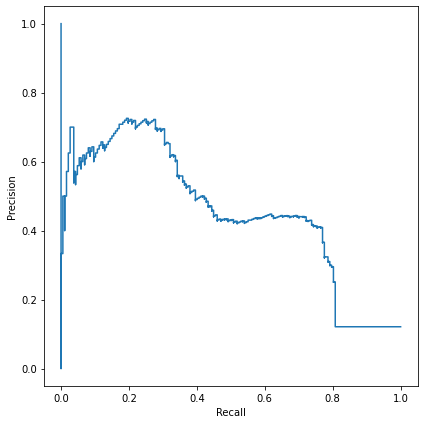

In [113]:
fig, ax = plt.subplots(figsize=(6, 6))
d.plot(ax=ax)
plt.tight_layout()
plt.show()

# Retrieval with LDA

In [114]:
from sklearn.decomposition import LatentDirichletAllocation

In [115]:
lda = LatentDirichletAllocation(n_components=200)

In [116]:
Xl = lda.fit_transform(X)
ql = lda.transform(q_vectors)

In [117]:
lda_sigma = cosine_similarity(ql, Xl)

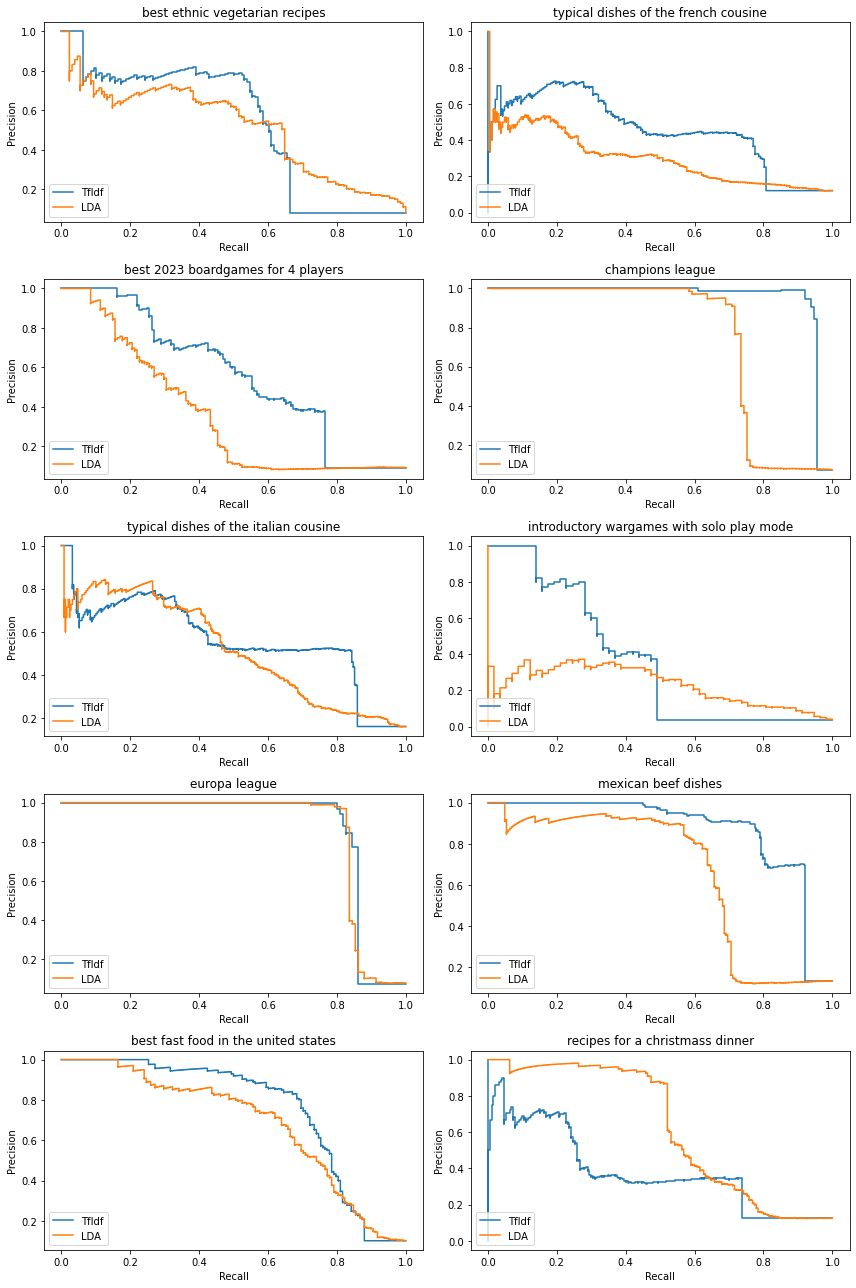

In [122]:
fig, ax = plt.subplots(figsize=(12, 18), ncols=2, nrows=5)
for i, q in enumerate(D['query'].unique()):
    row, col = i // 2, i % 2
    tfidf_d = evaluate(i, sigma)
    lda_d = evaluate(i, lda_sigma)
    tfidf_d.plot(ax=ax[row,col], label='TfIdf')
    lda_d.plot(ax=ax[row,col], label='LDA')
    ax[row,col].set_title(q)
plt.tight_layout()
plt.show()    